### **This recipe will show you how to evaluate the model temperature using moorings**

<br>

**Important note**: this script won't work if ran in a job on NCI when connected via VScode since it does not have network connection. You'll to run it from your browser!

<br>

**Output**\
This recipe creates netcdf files for each mooring location and the model point at the mooring location.\
The file will be saved into your local (./) directory.\
If you don't want file to be saved, change SAVING to False in the second cell.

<br>



- When you run the notebook, it will use OpenDAP to access IMOS mooring data from southeast Australia, and compare it with output from the ROMS-EAC ocean model. The model output is stored at NCI and available upon request.

- You’ll notice that the model point selected for comparison is not always the closest one geographically to the mooring. Instead, it’s the point with the most similar depth, chosen from within a specific range of longitudes. We chose longitudes because on the shelf longitudes change more drastically the depth not very far from the mooring location.

- This is because, in ocean models, depth often plays a bigger role than horizontal distance when comparing temperature. In many cases, the geographically nearest model point has a much different depth than the mooring, which can lead to a poor comparison of water column structure.

- Moorings are at daily sampling, same as model


<br>

#### **History**
- Originally created by Neil Malan
- Adapted and improved by Fernando Sobral on 5th Jun 2025

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import xroms
from cartopy import geodesic  # FS only way to get this module
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cmocean.cm as cmo

import xarray as xr
from siphon.catalog import TDSCatalog

In [2]:
# Set saving to True if you want files to be saved into your local directory and False if you don't
# False is the default.

saving=False

if saving:
    print('Files will be saved into your local directory.')
else:
    print('Files will NOT be saved into your local directory.')
    

Files will NOT be saved into your local directory.


In [3]:
#----------------------------------------------------------------
# 
def save_model_at_mooring(var, filename):
    data = var.data
    time = var.ocean_time.data
    depth = var.z_rho.mean('ocean_time').data
    nc = xr.Dataset(
        data_vars=dict(
            temp=(["time", "depth"], data)
        ),
        coords=dict(
            time=(["time"], time),
            depth=(["depth"], depth),
        ),
        attrs=dict(description="EAC_ROMS Vr at "+str(var)),
    )
    nc.to_netcdf(filename + '.nc')
    
#----------------------------------------------------------------
# 
def plot_moor_pos(model, lon_obs, lat_obs, lon_best, isobath, titlestring):
    '''
    This script subsample an area from the model to plot the bathymetry together with the mooring location and model location.

    '''
    dl = .3
    box = (model.lon_rho > lon_obs - dl) & (model.lon_rho < lon_obs + dl) & (model.lat_rho > lat_obs - dl) & (model.lat_rho < lat_obs + dl)
    dss = model.h.where(box.compute(), drop=True)
    dss.plot(x='lon_rho', y='lat_rho', vmax=200, cmap=cmo.deep)
    dss.plot.contour(x='lon_rho', y='lat_rho', levels=[isobath], colors='k', linestyles='--')
    plt.scatter(lon_obs, lat_obs, s=50, c = 'k', edgecolor='r', label = 'mooring location')
    plt.scatter(lon_best, lat_obs, s=50, c = 'k', edgecolor='w',label = 'validation location')
    plt.xlim(lon_obs - dl, lon_obs + dl)
    plt.ylim(lat_obs - dl, lat_obs + dl)
    plt.legend()
    plt.title(titlestring)

#----------------------------------------------------------------
# 
def load_latest_station_data(station_code, variable_keyword='TEMP'):
    """
    Loads the first NetCDF dataset that matches a variable from the specified station.
    
    Parameters:
    - station_code (str): 'CH070', 'CH100', 'SYD100', 'SYD140', 'BMP070', 'BMP120'
    - variable_keyword (str): partial match, e.g., 'TEMP'

    Returns:
    - xarray.Dataset
    """
    base_catalog_url = f'http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/{station_code}/gridded_timeseries/catalog.xml'
    
    print(f'{base_catalog_url}')

    catalog = TDSCatalog(base_catalog_url)
    
    # Filter dataset names with the keyword
    matching_datasets = [ds for ds in catalog.datasets if variable_keyword in ds]
    
    if not matching_datasets:
        raise ValueError(f"No datasets found for {station_code} with keyword '{variable_keyword}'")
    
    dataset_url = catalog.datasets[matching_datasets[0]].access_urls['OPENDAP']
    return xr.open_dataset(dataset_url)


In [4]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The return type of `Dataset.dims` will be changed.*"
)

def global_vars():
    # A basic chunk choice
    chunks = {'ocean_time': 1}

    glb_files = sorted(glob('/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his_*.nc'))
    
    ds = xroms.open_mfnetcdf(glb_files[16*12:16*16], chunks=chunks)
    print('global_vars: OK!')
    return ds


model = global_vars()


global_vars: OK!


#### Open mooring datasets using THREDDS

In [5]:
# Reading the MOORING data online

ch70   = load_latest_station_data('CH070' , 'TEMP')
ch100  = load_latest_station_data('CH100' , 'TEMP')
syd100 = load_latest_station_data('SYD100', 'TEMP')
syd140 = load_latest_station_data('SYD140', 'TEMP')
bmp70  = load_latest_station_data('BMP070', 'TEMP')
bmp120 = load_latest_station_data('BMP120', 'TEMP')


http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/CH070/gridded_timeseries/catalog.xml
http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/CH100/gridded_timeseries/catalog.xml
http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/SYD100/gridded_timeseries/catalog.xml
http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/SYD140/gridded_timeseries/catalog.xml
http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/BMP070/gridded_timeseries/catalog.xml
http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/NSW/BMP120/gridded_timeseries/catalog.xml


#### Make depth axis negative

In [6]:
ch100['DEPTH_1']  = ch100.DEPTH * -1
ch70['DEPTH_1']   = ch70.DEPTH * -1
syd100['DEPTH_1'] = syd100.DEPTH * -1
syd140['DEPTH_1'] = syd140.DEPTH * -1
bmp120['DEPTH_1'] = bmp120.DEPTH * -1
bmp70['DEPTH_1']  = bmp120.DEPTH * -1

### Functions to find the closest point and collecting it

In [7]:
def find_best_model_depth(moor_lon, moor_lat, moor_depth, model_lon, model_lat, model_h, nm):
    print('\nDoing for %s' % nm)
    # Getting the deepest point from the mooring
    moor_deepest = np.min(moor_depth)

    # Finding the resolution for the longitude in the model
    # The resolution will be used to give a range to look in the model for the best location
    # The range used is 10x the mooring location.
    resol = np.min(np.diff(model_lon))
    st = moor_lon - (resol*10)
    nd = moor_lon + (resol*10)
    print('This is the original mooring longitude: %s' % moor_lon.data)
    print('This is the starting range mooring longitude: %s' % st.data)
    print('This is the ending range mooring longitude: %s' % nd.data)
    
    # Creating a mononically increasing longitudes from the range above.
    # In the end, IDX will contain the longitude with closest depth value.
    seed_array = np.linspace(st.values, nd.values, 20)
    depth_diff = list()
    sto_model_idx = list()
    for tlon in seed_array:
        # Gets model depth from the closest point just changing the longitude TLON for this loop
        model_depth = xroms.sel2d(model_h, model_lon, model_lat, tlon, moor_lat)
        depth_diff.append(abs(abs(moor_deepest) - model_depth.values))
        sto_model_idx.append(model_depth.values)
    idx = np.argsort(depth_diff)[0]
    print('For the longitude %s, the depth difference between mooring and model is %s meters' % (seed_array[idx], np.round(depth_diff[idx].data, 2)))
    print('Mooring depth is %s and model depth is %s meters.\n' % (abs(moor_deepest.data), sto_model_idx[idx]))
    return seed_array[idx]

In [8]:
# Getting model latitude and longitude

lon = model.lon_rho.values
lat = model.lat_rho.values


## Coffs coordinates

In [9]:
ch100_lon, ch100_lat = ch100.LONGITUDE, ch100.LATITUDE
ch100_lon_best = find_best_model_depth(ch100_lon, ch100_lat, ch100.DEPTH_1, lon, lat, model.h, 'CH100')



Doing for CH100
This is the original mooring longitude: 153.39467638448156
This is the starting range mooring longitude: 153.15989560286056
This is the ending range mooring longitude: 153.62945716610255
For the longitude 153.3328919682655, the depth difference between mooring and model is 2.81 meters
Mooring depth is 100.0 and model depth is 102.80735595620385 meters.



In [10]:
ch70_lon, ch70_lat = ch70.LONGITUDE, ch70.LATITUDE
ch70_lon_best = find_best_model_depth(ch70_lon, ch70_lat, ch70.DEPTH_1, lon, lat, model.h, 'CH70')


Doing for CH70
This is the original mooring longitude: 153.29894541070223
This is the starting range mooring longitude: 153.06416462908123
This is the ending range mooring longitude: 153.53372619232323
For the longitude 153.23716099448617, the depth difference between mooring and model is 4.54 meters
Mooring depth is 70.0 and model depth is 65.46078000367982 meters.



### Sydney Coordinates

In [11]:
syd100_lon, syd100_lat = syd100.LONGITUDE, syd100.LATITUDE
syd100_lon_best = find_best_model_depth(syd100_lon, syd100_lat, syd100.DEPTH_1, lon, lat, model.h, 'SYD100')


Doing for SYD100
This is the original mooring longitude: 151.38219193548636
This is the starting range mooring longitude: 151.14741115386536
This is the ending range mooring longitude: 151.61697271710736
For the longitude 151.34512128575673, the depth difference between mooring and model is 0.84 meters
Mooring depth is 100.0 and model depth is 100.84292361346883 meters.



In [12]:
syd140_lon, syd140_lat = syd140.LONGITUDE, syd140.LATITUDE
syd140_lon_best = find_best_model_depth(syd140_lon, syd140_lat, syd140.DEPTH_1, lon, lat, model.h, 'SYD140')


Doing for SYD140
This is the original mooring longitude: 151.45156926424784
This is the starting range mooring longitude: 151.21678848262684
This is the ending range mooring longitude: 151.68635004586883
For the longitude 151.36507108154535, the depth difference between mooring and model is 3.74 meters
Mooring depth is 140.0 and model depth is 136.26171986355405 meters.



### Narooma coordinates

In [13]:
bmp120_lon, bmp120_lat = bmp120.LONGITUDE, bmp120.LATITUDE
bmp120_lon_best = find_best_model_depth(bmp120_lon, bmp120_lat, bmp120.DEPTH_1, lon, lat, model.h, 'BMP120')


Doing for BMP120
This is the original mooring longitude: 150.31459729499056
This is the starting range mooring longitude: 150.07981651336956
This is the ending range mooring longitude: 150.54937807661156
For the longitude 150.22809911228808, the depth difference between mooring and model is 11.44 meters
Mooring depth is 120.0 and model depth is 108.55769096114123 meters.



In [14]:
bmp70_lon, bmp70_lat = bmp70.LONGITUDE, bmp70.LATITUDE
bmp70_lon_best = find_best_model_depth(bmp70_lon, bmp70_lat, bmp70.DEPTH_1, lon, lat, model.h, 'BMP70')


Doing for BMP70
This is the original mooring longitude: 150.18929595959239
This is the starting range mooring longitude: 149.9545151779714
This is the ending range mooring longitude: 150.42407674121338
For the longitude 150.20165284283559, the depth difference between mooring and model is 6.51 meters
Mooring depth is 70.0 and model depth is 76.51178750707223 meters.



### Plot locations for sanity check:

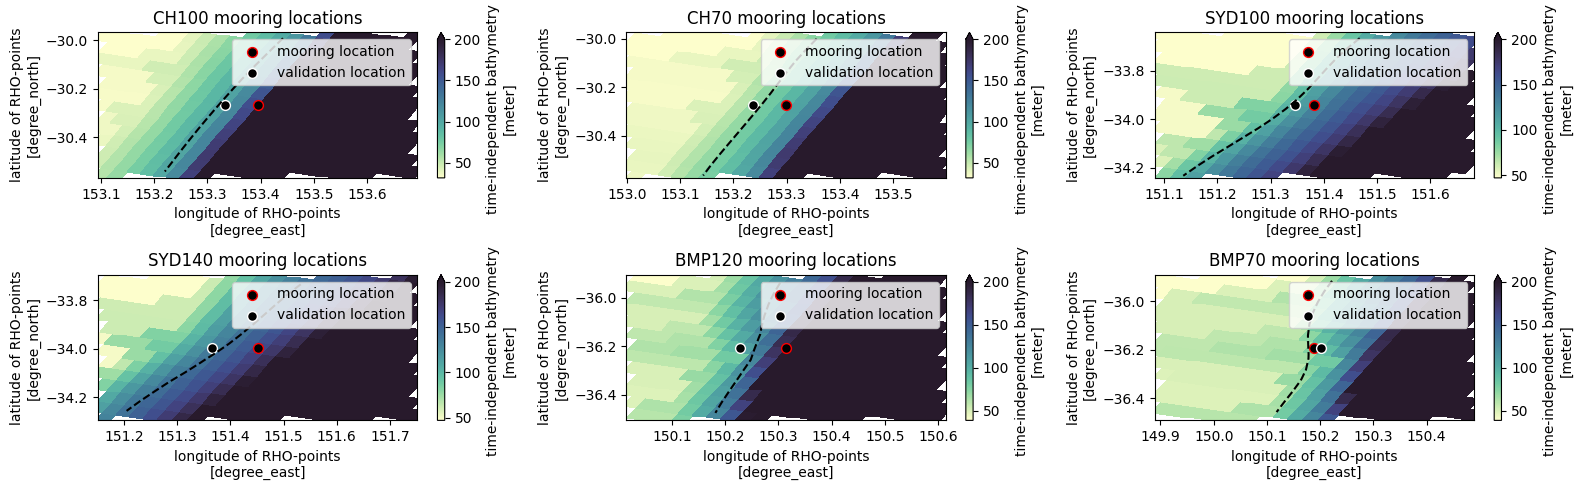

In [15]:
fig = plt.figure(figsize=(16,5))
plt.subplot(2, 3, 1)
plot_moor_pos(model, ch100_lon, ch100_lat, ch100_lon_best, 100, 'CH100 mooring locations')
plt.subplot(2, 3, 2)
plot_moor_pos(model, ch70_lon, ch70_lat, ch70_lon_best, 70, 'CH70 mooring locations')
plt.subplot(2, 3, 3)
plot_moor_pos(model, syd100_lon, syd100_lat, syd100_lon_best, 100, 'SYD100 mooring locations')
plt.subplot(2, 3, 4)
plot_moor_pos(model, syd140_lon, syd140_lat, syd140_lon_best, 140, 'SYD140 mooring locations')
plt.subplot(2, 3, 5)
plot_moor_pos(model, bmp120_lon, bmp120_lat, bmp120_lon_best, 120, 'BMP120 mooring locations')
plt.subplot(2, 3, 6)
plot_moor_pos(model, bmp70_lon, bmp70_lat, bmp70_lon_best, 70, 'BMP70 mooring locations')
plt.tight_layout()


In [16]:
# Using the best location with the longitude information, and the original mooring latitude, we will get the model time-series from that point
# We will compare the same days from mooring and model

model_ch100  = xroms.sel2d(model.temp, lon, lat, ch100_lon_best, ch100_lat).sel(ocean_time=slice(ch100.TIME[0], model.ocean_time[-1])).load()
model_ch70   = xroms.sel2d(model.temp, lon, lat, ch70_lon_best, ch70_lat).sel(ocean_time=slice(ch70.TIME[0], model.ocean_time[-1])).load()
model_syd100 = xroms.sel2d(model.temp, lon, lat, syd100_lon_best, syd100_lat).sel(ocean_time=slice(syd100.TIME[0], model.ocean_time[-1])).load()
model_syd140 = xroms.sel2d(model.temp, lon, lat, syd140_lon_best, syd140_lat).sel(ocean_time=slice(syd140.TIME[0], model.ocean_time[-1])).load()
model_bmp120 = xroms.sel2d(model.temp, lon, lat, bmp120_lon_best, bmp120_lat).sel(ocean_time=slice(bmp120.TIME[0], model.ocean_time[-1])).load()
model_bmp70  = xroms.sel2d(model.temp, lon, lat, bmp70_lon_best, bmp70_lat).sel(ocean_time=slice(bmp70.TIME[0], model.ocean_time[-1])).load()


### Save out temperature timeseries from model and moorings

In [17]:
if saving:
    print('Saving model files now...')
    save_model_at_mooring(model_ch100 , 'model_ch100' )
    save_model_at_mooring(model_ch70  , 'model_ch70'  )
    save_model_at_mooring(model_syd100, 'model_syd100')
    save_model_at_mooring(model_syd140, 'model_syd140')
    save_model_at_mooring(model_bmp120, 'model_bmp120')
    save_model_at_mooring(model_bmp70 , 'model_bmp70' )

    print('Saving mooring files now...')
    ch70 
    ch100
    syd100
    syd140
    bmp70
    bmp120

### Plot time-mean profiles to compare

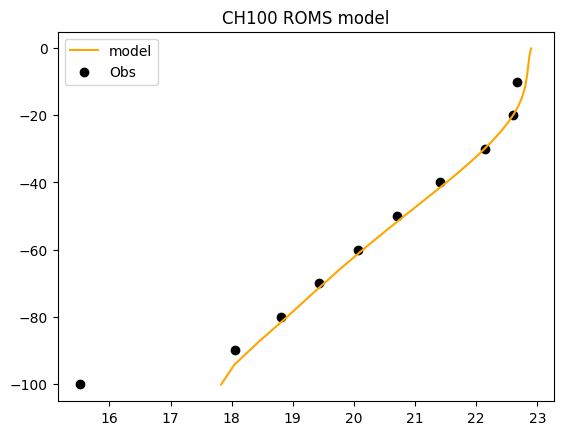

In [18]:
model_time = model_ch100.mean('ocean_time')
model_depth = model_ch100.z_rho.mean('ocean_time')
ch100_cut = ch100.TEMP.sel(TIME=slice(ch100.TIME[0], model.ocean_time[-1])).mean('TIME')
plt.plot(model_time, model_depth, color='orange', label='model')
plt.scatter(ch100_cut, ch100.DEPTH_1, color='k', label='Obs')
plt.title('CH100 ROMS model')
plt.legend()
# plt.savefig('model_ch100_temp.png',format="png",bbox_inches='tight',pad_inches=0.1, dpi=100)

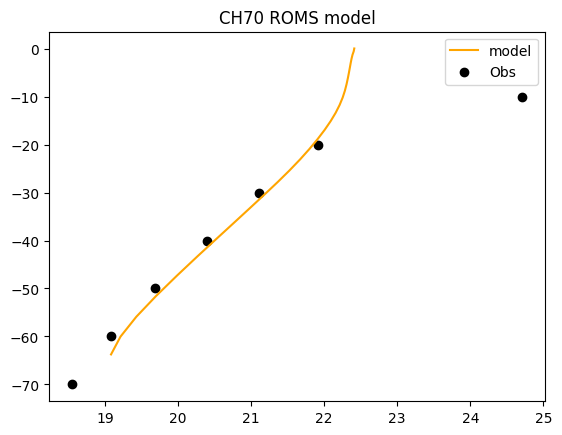

In [19]:
model_time = model_ch70.mean('ocean_time')
model_depth = model_ch70.z_rho.mean('ocean_time')
ch70_cut = ch70.TEMP.sel(TIME=slice(ch70.TIME[0], model.ocean_time[-1])).mean('TIME')
plt.plot(model_time, model_depth, color='orange', label='model')
plt.scatter(ch70_cut, ch70.DEPTH_1, color='k', label='Obs')
plt.title('CH70 ROMS model')
plt.legend()
# plt.savefig('model_ch70_temp.png', format="png",bbox_inches='tight',pad_inches=0.1, dpi=100)

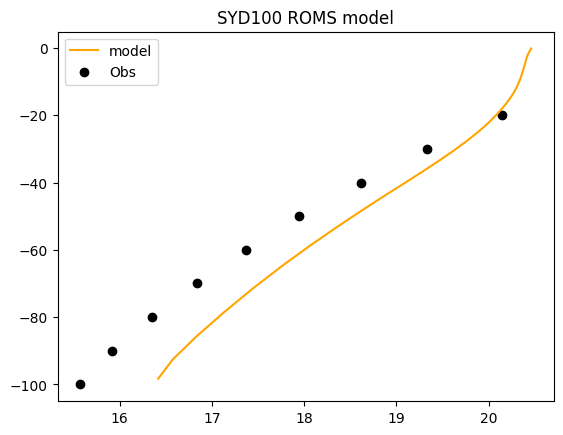

In [20]:
model_time = model_syd100.mean('ocean_time')
model_depth = model_syd100.z_rho.mean('ocean_time')
syd100_cut = syd100.TEMP.sel(TIME=slice(syd100.TIME[0], model.ocean_time[-1])).mean('TIME')
plt.plot(model_time, model_depth, color='orange', label='model')
plt.scatter(syd100_cut, syd100.DEPTH_1, color='k', label='Obs')
plt.title('SYD100 ROMS model')
plt.legend()
# plt.savefig('model_syd100_temp.png',format="png",bbox_inches='tight',pad_inches=0.1, dpi=100)

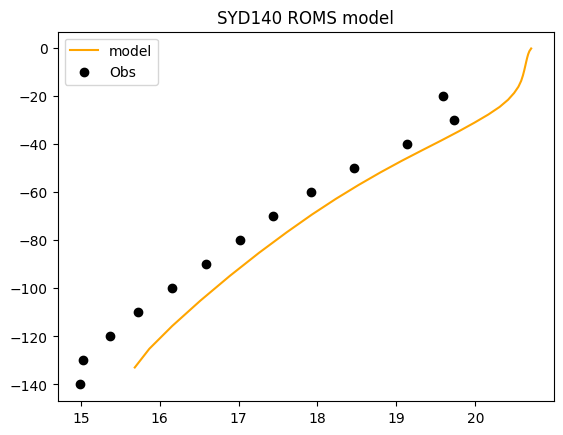

In [21]:
model_time = model_syd140.mean('ocean_time')
model_depth = model_syd140.z_rho.mean('ocean_time')
syd140_cut = syd140.TEMP.sel(TIME=slice(syd140.TIME[0], model.ocean_time[-1])).mean('TIME')
plt.plot(model_time, model_depth, color='orange', label='model')
plt.scatter(syd140_cut, syd140.DEPTH_1, color='k', label='Obs')
plt.title('SYD140 ROMS model')
plt.legend()
# plt.savefig('model_syd140_temp.png',format="png",bbox_inches='tight',pad_inches=0.1, dpi=100)

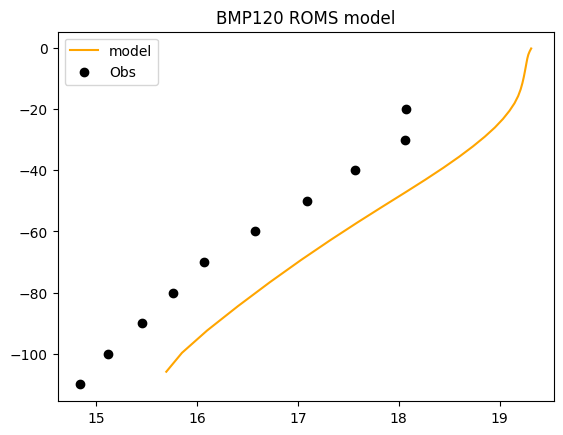

In [22]:
model_time = model_bmp120.mean('ocean_time')
model_depth = model_bmp120.z_rho.mean('ocean_time')
bmp120_cut = bmp120.TEMP.sel(TIME=slice(bmp120.TIME[0], model.ocean_time[-1])).mean('TIME')
plt.plot(model_time, model_depth, color='orange', label='model')
plt.scatter(bmp120_cut, bmp120.DEPTH_1, color='k', label='Obs')
plt.title('BMP120 ROMS model')
plt.legend()
# plt.savefig('model_bmp120_temp.png',format="png",bbox_inches='tight',pad_inches=0.1, dpi=100)

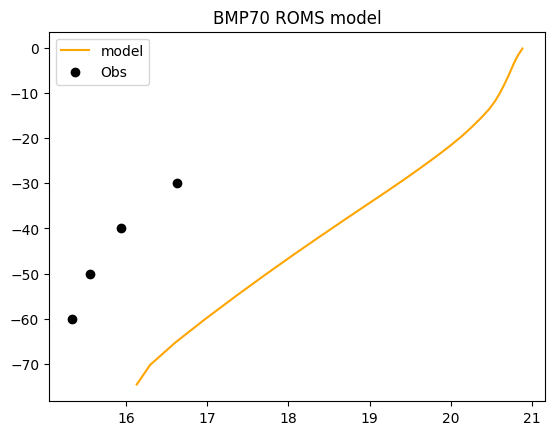

In [23]:
model_time = model_bmp70.mean('ocean_time')
model_depth = model_bmp70.z_rho.mean('ocean_time')
bmp70_cut = bmp70.TEMP.sel(TIME=slice(bmp70.TIME[0], model.ocean_time[-1])).mean('TIME')
plt.plot(model_time, model_depth, color='orange', label='model')
plt.scatter(bmp70_cut, bmp70.DEPTH_1, color='k', label='Obs')
plt.title('BMP70 ROMS model')
plt.legend()
# plt.savefig('model_bmp70_temp.png',format="png",bbox_inches='tight',pad_inches=0.1, dpi=100)